In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True})
%config InlineBackend.figure_formats = ['svg']
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ARIMA, SARIMAX
import warnings
warnings.filterwarnings("ignore")
import itertools

In [2]:
data = sm.datasets.co2.load_pandas()
co2 = data.data
print(co2.info())
print(co2.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB
None
              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4


5


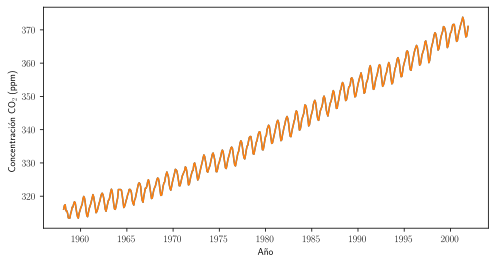

In [3]:
y = co2['co2'].resample('MS').mean()
print(y.isnull().sum())
y = y.fillna(method='backfill')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(y)
plt.xlabel('Año')
plt.ylabel(r'Concentración CO$_2$ (ppm)')
plt.plot(y);

In [4]:
def check_stationary(values): 
    dftest = adfuller(values, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    mensaje = "\t{}: {} - Los datos {} estacionarios con {}% de confianza"
    for k, v in dftest[4].items():
        print(mensaje.format(k, v, "no son" if v<dftest[0] else "son", 100-int(k[:-1])))

In [5]:
check_stationary(y)

Test statistic = 2.360
P-value = 0.999
Critical values :
	1%: -3.4432119442564324 - Los datos no son estacionarios con 99% de confianza
	5%: -2.8672126791646955 - Los datos no son estacionarios con 95% de confianza
	10%: -2.569791324979607 - Los datos no son estacionarios con 90% de confianza


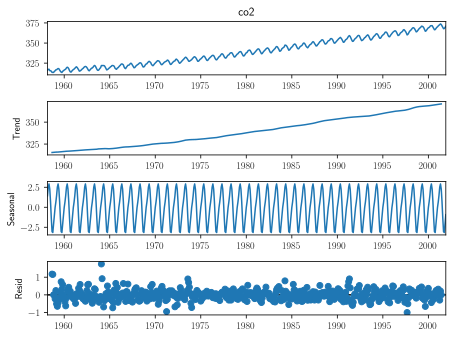

In [6]:
result = seasonal_decompose(y, model='additive', period=12)
result.plot();

In [7]:
check_stationary(result.seasonal)

Test statistic = -190285817600000.906
P-value = 0.000
Critical values :
	1%: -3.443161545965353 - Los datos son estacionarios con 99% de confianza
	5%: -2.8671904981615706 - Los datos son estacionarios con 95% de confianza
	10%: -2.5697795041589244 - Los datos son estacionarios con 90% de confianza


Test statistic = -5.063
P-value = 0.000
Critical values :
	1%: -3.4432119442564324 - Los datos son estacionarios con 99% de confianza
	5%: -2.8672126791646955 - Los datos son estacionarios con 95% de confianza
	10%: -2.569791324979607 - Los datos son estacionarios con 90% de confianza


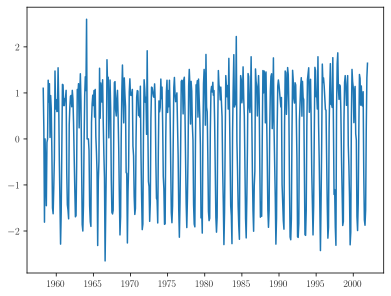

In [8]:
y_1 = y.diff()
check_stationary(y_1[1:])
plt.plot(y_1)

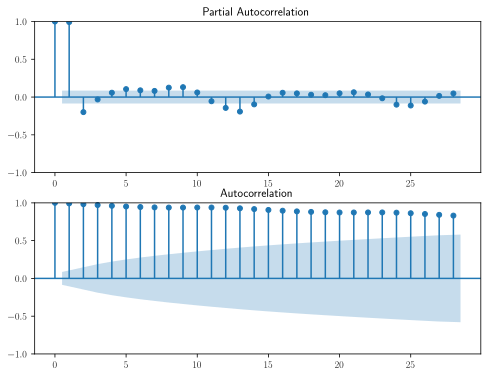

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_pacf(y, method='ywm', ax=ax1);
plot_acf(y, ax=ax2);

In [9]:
n_train = int(0.85 * y.size)
n_samples = y.size
n_valid = n_samples - n_train
y_train, y_valid = y[:n_train], y[n_train:]
print(f'Número de muestras: {n_samples}, entrenamiento: {n_train}, validación: {n_valid}')

Número de muestras: 526, entrenamiento: 447, validación: 79


In [10]:
model_evals = []
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_PDQ:
        try:
            mod = SARIMAX(y_train, order=param, seasonal_order=param_seasonal,
                                            enforce_stationary=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=0)
            model_evals.append([param, param_seasonal, results.aic, results.bic])
        except:
            continue                                      

In [14]:
for p in model_evals:
    if (p[2] < 300) or (p[3] < 300):
        print(f"AIC: {p[2]}, BIC: {p[3]}, (p, d, q)={p[0]}, (P, D, Q, 12)={p[1]}")


AIC: 10.0, BIC: 30.512792973067846, (p, d, q)=(0, 0, 0), (P, D, Q, 12)=(2, 0, 2, 12)
AIC: 10.0, BIC: 30.512792973067846, (p, d, q)=(0, 0, 1), (P, D, Q, 12)=(2, 0, 1, 12)
AIC: 12.0, BIC: 36.25579700209428, (p, d, q)=(0, 2, 2), (P, D, Q, 12)=(1, 2, 2, 12)
AIC: 14.0, BIC: 42.717910162294984, (p, d, q)=(1, 0, 2), (P, D, Q, 12)=(1, 0, 2, 12)
AIC: 296.9064313262613, BIC: 325.41774306496416, (p, d, q)=(1, 1, 1), (P, D, Q, 12)=(2, 1, 2, 12)
AIC: 299.38141802518373, BIC: 331.96577429798697, (p, d, q)=(1, 1, 2), (P, D, Q, 12)=(2, 1, 2, 12)
AIC: 8.0, BIC: 24.410234378454277, (p, d, q)=(2, 0, 0), (P, D, Q, 12)=(0, 0, 1, 12)
AIC: 10.0, BIC: 30.512792973067846, (p, d, q)=(2, 0, 0), (P, D, Q, 12)=(1, 0, 1, 12)
AIC: 10.0, BIC: 30.512792973067846, (p, d, q)=(2, 0, 1), (P, D, Q, 12)=(0, 0, 1, 12)
AIC: 299.73667810970073, BIC: 332.32103438250397, (p, d, q)=(2, 1, 1), (P, D, Q, 12)=(2, 1, 2, 12)


In [41]:
model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(2, 1, 2, 12),
                enforce_stationary=True, enforce_invertibility=False)
model_fit = model.fit(disp=0, maxiter=200)
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                     co2   No. Observations:                  447
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -141.453
Date:                                 Mon, 09 Jan 2023   AIC                            296.906
Time:                                         18:50:12   BIC                            325.418
Sample:                                     03-01-1958   HQIC                           308.160
                                          - 05-01-1995                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4175      0.083      5.020      0.000       0.254       0

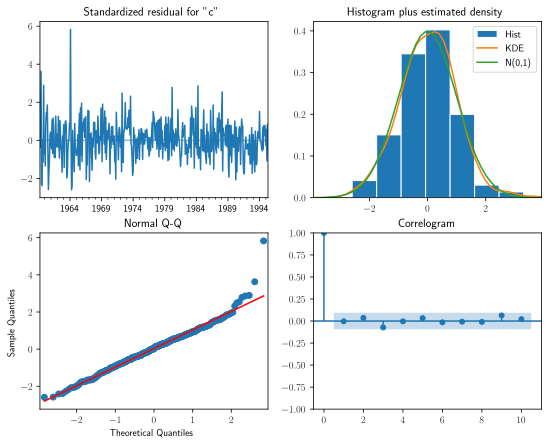

In [36]:
model_fit.plot_diagnostics(figsize=(9,7));

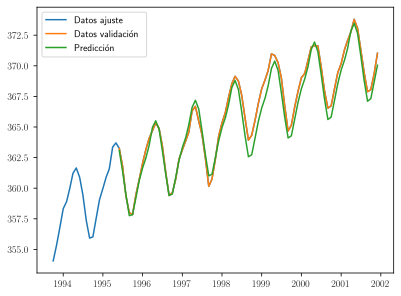

In [46]:
y_valid_fore = model_fit.forecast(steps=n_valid)
plt.plot(y[n_train-20:], label='Datos ajuste')
plt.plot(y_valid, label='Datos validación')
plt.plot(y_valid_fore, label='Predicción')
plt.legend(loc=2)
plt.show()


### Copyright 2020-2023 Facundo Batista y Manuel Carlevaro

Licencia CC BY-NC-SA 4.0

Para más info visitar: https://github.com/facundobatista/libro-pyciencia/

